In [1]:
pip install keras

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets


In [3]:

# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to [0, 1]


170498071/170498071 [==============================] - 3s 0us/step


In [4]:

# Define ResNet architecture
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 6, 3]
    filters_list = [64, 128, 256, 512]

    for stage, num_blocks, filters in zip(range(4), num_blocks_list, filters_list):
        strides = 1 if stage == 0 else 2  # Downsample the feature maps in the first block of each stage
        x = build_resnet_stage(x, filters, num_blocks, strides)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

def build_resnet_stage(x, filters, num_blocks, strides):
    for i in range(num_blocks):
        # First block in each stage might need to downsample spatially
        if i == 0:
            x = residual_block(x, filters, strides=strides)
        else:
            x = residual_block(x, filters, strides=1)
    return x

def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # If the input shape is not the same as the output shape, adjust the shortcut
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x


In [5]:

# Build and compile the model
input_shape = x_train[0].shape
num_classes = len(np.unique(y_train))
model = build_resnet(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [6]:

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/10
782/782 [==============================] - 62s 44ms/step - loss: 1.5274 - accuracy: 0.4630 - val_loss: 1.4571 - val_accuracy: 0.4995
Epoch 2/10
782/782 [==============================] - 33s 43ms/step - loss: 1.0705 - accuracy: 0.6241 - val_loss: 1.7360 - val_accuracy: 0.4708
Epoch 3/10
782/782 [==============================] - 33s 42ms/step - loss: 0.9047 - accuracy: 0.6855 - val_loss: 1.0574 - val_accuracy: 0.6377
Epoch 4/10
782/782 [==============================] - 32s 41ms/step - loss: 0.8105 - accuracy: 0.7186 - val_loss: 0.9541 - val_accuracy: 0.6759
Epoch 5/10
782/782 [==============================] - 33s 43ms/step - loss: 0.7694 - accuracy: 0.7355 - val_loss: 1.5087 - val_accuracy: 0.5447
Epoch 6/10
782/782 [==============================] - 32s 41ms/step - loss: 0.6263 - accuracy: 0.7833 - val_loss: 0.9913 - val_accuracy: 0.6726
Epoch 7/10
782/782 [==============================] - 32s 41ms/step - loss: 0.5660 - accuracy: 0.8063 - val_loss: 1.2354 - val_accuracy:

In [7]:

# Make predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)


313/313 [==============================] - 3s 8ms/step


In [8]:

# Print some example predictions
print("Example predictions:")
for i in range(10):
    print(f"Predicted class: {predicted_classes[i]}, True class: {y_test[i][0]}")


Example predictions:
Predicted class: 3, True class: 3
Predicted class: 8, True class: 8
Predicted class: 8, True class: 8
Predicted class: 0, True class: 0
Predicted class: 6, True class: 6
Predicted class: 6, True class: 6
Predicted class: 1, True class: 1
Predicted class: 6, True class: 6
Predicted class: 2, True class: 3
Predicted class: 1, True class: 1


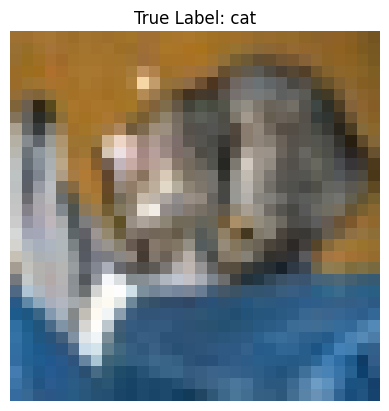

1/1 [==============================] - 0s 486ms/step
True Label: cat
Predicted Percentage for airplane: 0.10%
Predicted Percentage for automobile: 0.36%
Predicted Percentage for bird: 0.19%
Predicted Percentage for cat: 89.87%
Predicted Percentage for deer: 0.07%
Predicted Percentage for dog: 0.58%
Predicted Percentage for frog: 8.34%
Predicted Percentage for horse: 0.01%
Predicted Percentage for ship: 0.31%
Predicted Percentage for truck: 0.15%
Predicted Class: cat


In [9]:
import matplotlib.pyplot as plt

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Select an image from the test set
image_index = 0
test_image = x_test[image_index]
true_label = y_test[image_index][0]

# Reshape the image to its original dimensions (32x32x3)
test_image = test_image.reshape((32, 32, 3))

# Display the image
plt.imshow(test_image)
plt.title(f"True Label: {class_names[true_label]}")
plt.axis('off')
plt.show()

# Reshape the image to match the input shape of the model (1x32x32x3)
test_image = test_image[np.newaxis, ...]

# Predict the probabilities for the image
predicted_probabilities = model.predict(test_image)[0]

# Get the true label name
true_label_name = class_names[true_label]

# Display the true label name
print(f"True Label: {true_label_name}")

# Calculate and display the percentage of all predictions
total_probability = sum(predicted_probabilities)
for i, prob in enumerate(predicted_probabilities):
    class_name = class_names[i]
    percentage = (prob / total_probability) * 100
    print(f"Predicted Percentage for {class_name}: {percentage:.2f}%")

# Get the predicted class
predicted_class = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_class]

# Display the predicted class name
print(f"Predicted Class: {predicted_class_name}")
